In [3]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
server = 'arc'

In [4]:
# Get model
from model import get_custom_model

#### CHANGE MODEL AND CHECKPOINT_PATH
MODEL = 'resnet18'
N_CLASSES = 4


model = get_custom_model(
    model_name=MODEL,
    num_classes=N_CLASSES,
    pretrained=False
)

model = model.to(device)

In [5]:
# Get checkpoint
checkpoint_path = '/home/ksmehrab/FishDatasetTrack/Identification/TraitIDBasic/Outputs/results_r18_wbce_basic/ckpt_9229_S9229_tid_r18_basic_fishair_processed_resnet18.t7'
ckpt_t = torch.load(checkpoint_path)
model.load_state_dict(ckpt_t['net'])
epoch = ckpt_t['epoch']

In [6]:
# Get test loader
from pathlib import Path
if server == 'pda':
#     train_file = Path('/data/DatasetTrackFinalData/Identification/trait_identification_train.csv')
    val_file = Path('/data/DatasetTrackFinalData/Identification/trait_identification_val.csv')
    test_file = Path('/data/DatasetTrackFinalData/Identification/trait_identification_test_inspecies.csv')
    lv_sp_normal_test_file = Path('/data/DatasetTrackFinalData/Identification/trait_identification_test_leavespecies.csv')
    lv_sp_difficult_test_file = None
    img_dir = Path('/data/BGRemovedCropped/all')
elif server == 'arc':
#     train_file = Path('/projects/ml4science/FishDatasetTrack/DatasetTrackFinalData/Identification/trait_identification_train.csv')
    val_file = Path('/projects/ml4science/FishDatasetTrack/DatasetTrackFinalData/Identification/trait_identification_val.csv')
    test_file = Path('/projects/ml4science/FishDatasetTrack/DatasetTrackFinalData/Identification/trait_identification_test_inspecies.csv')
    lv_sp_normal_test_file = Path('/projects/ml4science/FishDatasetTrack/DatasetTrackFinalData/Identification/trait_identification_test_leavespecies.csv')
    lv_sp_difficult_test_file = Path('/projects/ml4science/FishDatasetTrack/DatasetTrackFinalData/Segmentation/annotations_mlic.csv')
    img_dir = Path('/projects/ml4science/FishAIR/BGRemovedCropped/all')

In [7]:
from data_setup import get_transform, get_dataset_and_dataloader

mean = torch.tensor([0.9353, 0.9175, 0.8923])
std = torch.tensor([0.1535, 0.1933, 0.2464])
transform = get_transform(224, mean, std, 'squarepad_augment_normalize')
test_transform = get_transform(224, mean, std, 'squarepad_no_augment_normalize')

BATCH_SIZE=256
num_workers = 8

test_dataset, test_loader = get_dataset_and_dataloader(
    data_file=test_file,
    img_dir=img_dir,
    transform=test_transform,
    batch_size=BATCH_SIZE,
    num_workers=num_workers
)

val_dataset, val_loader = get_dataset_and_dataloader(
    data_file=val_file,
    img_dir=img_dir,
    transform=test_transform,
    batch_size=BATCH_SIZE,
    num_workers=num_workers
)

if lv_sp_normal_test_file:
    lv_sp_normal_dataset, lv_sp_normal_loader = get_dataset_and_dataloader(
        data_file=lv_sp_normal_test_file,
        img_dir=img_dir,
        transform=test_transform,
        batch_size=BATCH_SIZE,
        num_workers=num_workers
    )

if lv_sp_difficult_test_file:
    lv_sp_dif_dataset, lv_sp_dif_loader = get_dataset_and_dataloader(
        data_file=lv_sp_difficult_test_file,
        img_dir=img_dir,
        transform=test_transform,
        batch_size=BATCH_SIZE,
        num_workers=num_workers
    )


Matplotlib created a temporary cache directory at /localscratch/2418267/matplotlib-_bbawk3c because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [8]:
# Method for getting optimal threshold for each of the traits 
from sklearn.metrics import roc_curve, precision_recall_curve
from matplotlib import pyplot

def get_g_mean_threshold(net, dataloader, show_plot=False):
    """
    This method should be called on the validation dataloader 
    """
    is_training = net.training
    net.eval()
    criterion = nn.BCEWithLogitsLoss(reduce=True, reduction='mean')

    total_loss = 0.0
    total = 0.0

    all_predicted = []
    all_targets = []

    for inputs, targets in tqdm(dataloader):
        batch_size = inputs.size(0)
        inputs, targets = inputs.to(device), targets.to(device)
        
        with torch.inference_mode():
            outputs = net(inputs)
            loss = criterion(outputs, targets)
        # breakpoint()
        total_loss += loss.item() * batch_size

        predicted = torch.sigmoid(outputs) # Get probabilities
        
        all_predicted.append(predicted.cpu().detach().numpy())
        all_targets.append(targets.cpu().numpy())
        
        total += batch_size

    all_predicted = np.vstack(all_predicted)
    all_targets = np.vstack(all_targets)
    
    
    # change column 1 to 1 - all_predicted[1]
    # change column 1 to 1 - all_targets[1]
    all_predicted[:, 1] = 1 - all_predicted[:, 1]
    all_targets[:, 1] = 1 - all_targets[:, 1]
    
    best_thresholds = []
    for i in range(all_targets.shape[1]):
        fpr, tpr, thresholds = roc_curve(all_targets[:, i], all_predicted[:, i])
        gmeans = np.sqrt(tpr * (1-fpr))
        ix = np.argmax(gmeans)
        best_thresholds.append(thresholds[ix])
        
        if show_plot:
            pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
            pyplot.plot(fpr, tpr, marker='.', label='Logistic')
            pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
            # axis labels
            pyplot.xlabel('False Positive Rate')
            pyplot.ylabel('True Positive Rate')
            pyplot.legend()
            # show the plot
            pyplot.show()
    
    return np.array(best_thresholds)

In [11]:
import torch.nn as nn
from tqdm import tqdm
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score, average_precision_score, roc_auc_score

def get_optimal_threshold(
    net, dataloader, experiment_name,
    threshold_type = 'pr_curve', 
    show_plot=False,
    plot_save_filepath = None,
    traits_to_detect = ['adipose', 'pelvic', 'barbel', 'dorsal']
):
    is_training = net.training
    net.eval()
    criterion = nn.BCEWithLogitsLoss(reduce=True, reduction='mean')

    total_loss = 0.0
    total = 0.0

    all_predicted = []
    all_targets = []

    for inputs, targets in tqdm(dataloader):
        batch_size = inputs.size(0)
        inputs, targets = inputs.to(device), targets.to(device)
        
        with torch.inference_mode():
            outputs = net(inputs)
            loss = criterion(outputs, targets)
        # breakpoint()
        total_loss += loss.item() * batch_size
        
        predicted = torch.sigmoid(outputs) # Get probabilities
        
        all_predicted.append(predicted.cpu().detach().numpy())
        all_targets.append(targets.cpu().numpy())
        
        total += batch_size     

    all_predicted = np.vstack(all_predicted)
    all_targets = np.vstack(all_targets)
    
    # change column 1 to 1 - all_predicted[1]
    # change column 1 to 1 - all_targets[1]
    all_predicted[:, 1] = 1 - all_predicted[:, 1]
    all_targets[:, 1] = 1 - all_targets[:, 1]
    
    all_testy = []
    all_yhat = []
    for i in range(all_targets.shape[1]):
        if i != 3:
            all_testy.append(all_targets[:, i])
            all_yhat.append(all_predicted[:, i])
        elif i == 3:
            known_mask = all_targets[:, i] != -1.0
            all_testy.append(all_targets[:, i][known_mask])
            all_yhat.append(all_predicted[:, i][known_mask])
            
    if show_plot or plot_save_filepath:  
        fig, axs = pyplot.subplots(1, 4, figsize=(20, 5))
        
    if threshold_type == 'g_means':
        best_thresholds = []
        for i in range(all_targets.shape[1]):
            fpr, tpr, thresholds = roc_curve(all_targets[:, i], all_predicted[:, i])
            gmeans = np.sqrt(tpr * (1-fpr))
            ix = np.argmax(gmeans)
            best_thresholds.append(thresholds[ix])
            
            if show_plot or plot_save_filepath:
                axs[i].plot([0,1], [0,1], linestyle='--', label='No Skill')
                axs[i].plot(fpr, tpr, marker='.', label='Logistic')
                axs[i].scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
                axs[i].set_title(f'{traits_to_detect[i]}')
                # axis labels
                # axs[i].set_xlabel('False Positive Rate')
                # axs[i].set_ylabel('True Positive Rate')
                # axs[i].legend()

    elif threshold_type == 'pr_curve':
        best_thresholds = []
        for i in range(all_targets.shape[1]):
            testy = all_testy[i]
            yhat = all_yhat[i]
            precision, recall, thresholds = precision_recall_curve(testy, yhat)
            
            # convert to f score
            fscore = (2 * precision * recall) / (precision + recall)
            # locate the index of the largest f score
            ix = np.argmax(fscore)
            best_thresholds.append(thresholds[ix])
            
            if show_plot or plot_save_filepath:
                no_skill = len(testy[testy==1]) / len(testy)
                axs[i].plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
                axs[i].plot(recall, precision, marker='.', label='Logistic')
                axs[i].scatter(recall[ix], precision[ix], marker='o', color='black', label='Best', s=100, zorder=2)
                axs[i].set_title(f'{traits_to_detect[i]}')
                # axis labels
                # axs[i].set_xlabel('Recall')
                # axs[i].set_ylabel('Precision')
                # axs[i].legend()

            
    else:
        raise NotImplementedError('Threshold type not implemented')
    
    if show_plot or plot_save_filepath:  
        # Add a single x label and y label for the entire figure
        fig.text(0.5, 0.04, 'Recall', ha='center')
        fig.text(0.04, 0.5, 'Precision', va='center', rotation='vertical')

        # Add a single legend for the entire figure
        handles, labels = axs[0].get_legend_handles_labels()
        fig.legend(handles, labels, loc='upper right', ncol=2)
        pyplot.tight_layout(rect=[0.04, 0.04, 1, 0.96])
        fig.suptitle(f'{experiment_name}')
        if plot_save_filepath:
            assert plot_save_filepath.endswith('.pdf'), "Plt save files must be pdf"
            pyplot.savefig(plot_save_filepath, format='pdf', bbox_inches='tight')
        if show_plot:
            pyplot.show()
        pyplot.close()  
    
    return best_thresholds

/home/ksmehrab/.conda/envs/py39/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
100%|██████████| 21/21 [00:59<00:00,  2.83s/it]


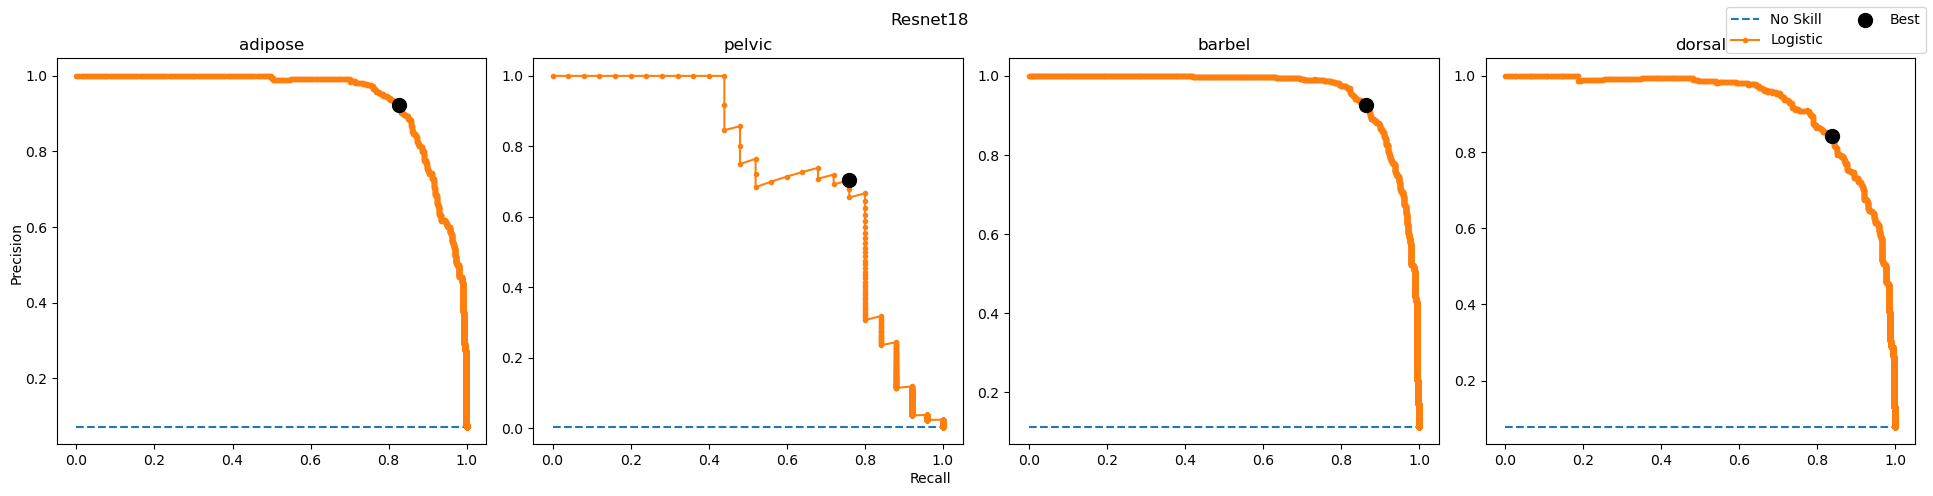

In [12]:
best_thresholds = get_optimal_threshold(
    model, val_loader, 'Resnet18',
    threshold_type = 'pr_curve', 
    show_plot=True, 
    plot_save_filepath=None
)

In [17]:
best_thresholds

[0.16538645, 0.5500885, 0.41897866, 0.14108688]

In [18]:
def evaluate(
    net, dataloader, type, best_thresholds
):
    is_training = net.training
    net.eval()
    criterion = nn.BCEWithLogitsLoss(reduce=True, reduction='mean')

    total_loss = 0.0
    total = 0.0

    all_predicted = []
    all_targets = []

    for inputs, targets in tqdm(dataloader):
        batch_size = inputs.size(0)
        inputs, targets = inputs.to(device), targets.to(device)
        
        with torch.inference_mode():
            outputs = net(inputs)
            loss = criterion(outputs, targets)
        # breakpoint()
        total_loss += loss.item() * batch_size
        
        predicted = torch.sigmoid(outputs) # Get probabilities
        
        all_predicted.append(predicted.cpu().detach().numpy())
        all_targets.append(targets.cpu().numpy())
        
        total += batch_size     

    all_predicted = np.vstack(all_predicted)
    all_targets = np.vstack(all_targets)
    
    # change column 1 to 1 - all_predicted[1]
    # change column 1 to 1 - all_targets[1]
    all_predicted[:, 1] = 1 - all_predicted[:, 1]
    all_targets[:, 1] = 1 - all_targets[:, 1]
    
    all_testy = []
    all_yhat = []
    for i in range(all_targets.shape[1]):
        if i != 3:
            all_testy.append(all_targets[:, i])
            all_yhat.append(all_predicted[:, i])
        elif i == 3:
            known_mask = all_targets[:, i] != -1.0
            all_testy.append(all_targets[:, i][known_mask])
            all_yhat.append(all_predicted[:, i][known_mask])
    
#     print(all_targets.shape[1])
#     print(sum(known_mask))
#     print(all_testy[0].shape)
    
    average_precisions = []
    for i in range(all_targets.shape[1]):
        ap = average_precision_score(all_testy[i], all_yhat[i], average='macro')
        average_precisions.append(ap)   

#     average_precisions = list(average_precision_score(all_targets, all_predicted, average=None))

    mean_ap = np.mean(average_precisions)
#     print(f'Mean Average Precision: {mean_ap}')
    
    roc_aucs = []
    for i in range(all_targets.shape[1]):
        roc = roc_auc_score(all_testy[i], all_yhat[i], average='macro')
        roc_aucs.append(roc)
    
#     roc_aucs = list(roc_auc_score(all_targets, all_predicted, average=None))

    mean_roc_auc = np.mean(roc_aucs)
    
    all_preds_threshold = all_predicted >= best_thresholds
    all_preds_threshold = all_preds_threshold.astype(int)

    f1s_t = []
    precisions_t = []
    recalls_t = []
    for i in range(all_targets.shape[1]):
        f1 = f1_score(all_targets[:, i], all_preds_threshold[:, i], average='macro')
        f1s_t.append(f1)
        precision = precision_score(all_targets[:, i], all_preds_threshold[:, i], average='macro')
        precisions_t.append(precision)
        recall = recall_score(all_targets[:, i], all_preds_threshold[:, i], average='macro')
        recalls_t.append(recall)
    
    all_preds_threshold = all_predicted >= 0.5
    all_preds_threshold = all_preds_threshold.astype(int)

    f1s = []
    precisions = []
    recalls = []
    for i in range(all_targets.shape[1]):
        f1 = f1_score(all_targets[:, i], all_preds_threshold[:, i], average='macro')
        f1s.append(f1)
        precision = precision_score(all_targets[:, i], all_preds_threshold[:, i], average='macro')
        precisions.append(precision)
        recall = recall_score(all_targets[:, i], all_preds_threshold[:, i], average='macro')
        recalls.append(recall)
          
        
    eps = 0.000001
    results = {
        'loss': total_loss / (total + eps),
        'aps': average_precisions,
        'map': mean_ap,
        'roc_aucs': roc_aucs,
        'mean_roc_auc': mean_roc_auc,
        'f1': f1s,
        'precision': precisions,
        'recall': recalls,
        'f1_t': f1s_t,
        'precision_t': precisions_t,
        'recall_t': recalls_t
    }


    msg = f"{type} | Loss: {total_loss / (total + eps)} | AP: {average_precisions} | MAP: {mean_ap} | ROC_AUCS: {roc_aucs} | mROC_AUC: {mean_roc_auc} | f1: {f1s} | Precs: {precisions} | Recs: {recalls}"
    
    print(msg)

    net.train(is_training)
    return results

In [19]:
results = evaluate(model, lv_sp_normal_loader, 'lv_sp_normal_loader', best_thresholds)

/home/ksmehrab/.conda/envs/py39/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
100%|██████████| 7/7 [00:47<00:00,  6.77s/it]


4
1644
(1644,)
lv_sp_normal_loader | Loss: 0.137294312116852 | AP: [0.8193635894699989, 0.24357637811429395, 0.8187658680116812, 0.12314726865279702] | MAP: 0.5012132760621928 | ROC_AUCS: [0.9853245346203092, 0.7320140177283034, 0.9886332446833682, 0.6511075129533679] | mROC_AUC: 0.8392698274963372 | f1: [0.79059732142025, 0.6678933731500594, 0.8368340011399502, 0.5423911975636114] | Precs: [0.9872986369268897, 0.8685819070904646, 0.9227556818181819, 0.5609481827995682] | Recs: [0.7112676056338028, 0.6104926819212533, 0.7816797433252255, 0.5351036269430052]


In [26]:
import json
def evaluate_all_tests(
    net, all_test_loaders, best_thresholds, 
    save_filepath=None
):
    all_results = {}
    for k, v in all_test_loaders.items():
        print(f'Running on test: {k}')
        results = evaluate(net, v, k, best_thresholds)
        all_results[k] = results
        
    if save_filepath:
        assert save_filepath.endswith('json'), "Save file must be json"
        with open(save_filepath, 'w') as f:
            json.dump(all_results, f)
        
    
    return all_results

In [27]:
all_test_loaders = {
    'normal_test': test_loader, 
    'leave_species_test': lv_sp_normal_loader,
    'annotated_test': lv_sp_dif_loader
}
all_results = evaluate_all_tests(model, all_test_loaders, best_thresholds, 'trial_save.json')

/home/ksmehrab/.conda/envs/py39/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Running on test: normal_test


100%|██████████| 32/32 [01:32<00:00,  2.90s/it]
/home/ksmehrab/.conda/envs/py39/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


4
8070
(8070,)
normal_test | Loss: 0.05800318028714651 | AP: [0.9648156799244966, 0.655543574647596, 0.9507572759517611, 0.9241278233377175] | MAP: 0.8738110884653928 | ROC_AUCS: [0.9961107382979346, 0.9768181818181818, 0.9874784463388667, 0.986031895179182] | mROC_AUC: 0.9866098154085413 | f1: [0.9128380199908755, 0.7862038892719589, 0.9369747872262655, 0.9086485116117279] | Precs: [0.9877623915593143, 0.7650226343942017, 0.9587613924150415, 0.9719033088909881] | Recs: [0.8599808131427216, 0.8111301369863013, 0.9176907459250918, 0.8624884503954271]
Running on test: leave_species_test


100%|██████████| 7/7 [00:46<00:00,  6.63s/it]
/home/ksmehrab/.conda/envs/py39/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


4
1644
(1644,)
leave_species_test | Loss: 0.137294312116852 | AP: [0.8193635894699989, 0.24357637811429395, 0.8187658680116812, 0.12314726865279702] | MAP: 0.5012132760621928 | ROC_AUCS: [0.9853245346203092, 0.7320140177283034, 0.9886332446833682, 0.6511075129533679] | mROC_AUC: 0.8392698274963372 | f1: [0.79059732142025, 0.6678933731500594, 0.8368340011399502, 0.5423911975636114] | Precs: [0.9872986369268897, 0.8685819070904646, 0.9227556818181819, 0.5609481827995682] | Recs: [0.7112676056338028, 0.6104926819212533, 0.7816797433252255, 0.5351036269430052]
Running on test: annotated_test


100%|██████████| 10/10 [01:18<00:00,  7.80s/it]

4
313
(2427,)
annotated_test | Loss: -0.7409051723651109 | AP: [0.49488642775129565, 0.11439460937968329, 0.4947791724529732, 0.615042463588849] | MAP: 0.42977566829320024 | ROC_AUCS: [0.798734212211834, 0.61150512214342, 0.839868512924032, 0.9190277777777778] | mROC_AUC: 0.7922839062642659 | f1: [0.5441448059926868, 0.5183750224431362, 0.7153955698569597, 0.09635833510934971] | Precs: [0.7924059991550485, 0.5329580321389568, 0.7460593620337643, 0.05776480691692989] | Recs: [0.5478385533063925, 0.5164279270872216, 0.6937092559435338, 0.37333333333333335]



/home/ksmehrab/.conda/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ksmehrab/.conda/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [17]:
# Evaluate
# evaluate method from config

def evaluate_compute_threshold_on_data(net, dataloader, type, threshold_type, show_curves=False):
    is_training = net.training
    net.eval()
    criterion = nn.BCEWithLogitsLoss(reduce=True, reduction='mean')

    total_loss = 0.0
    total = 0.0

    all_predicted = []
    all_targets = []

    for inputs, targets in tqdm(dataloader):
        batch_size = inputs.size(0)
        inputs, targets = inputs.to(device), targets.to(device)
        
        with torch.inference_mode():
            outputs = net(inputs)
            loss = criterion(outputs, targets)
        # breakpoint()
        total_loss += loss.item() * batch_size

        predicted = torch.sigmoid(outputs) # Get probabilities
        
        all_predicted.append(predicted.cpu().detach().numpy())
        all_targets.append(targets.cpu().numpy())
        
        total += batch_size

    all_predicted = np.vstack(all_predicted)
    all_targets = np.vstack(all_targets)
    
    
    # change column 1 to 1 - all_predicted[1]
    # change column 1 to 1 - all_targets[1]
    all_predicted[:, 1] = 1 - all_predicted[:, 1]
    all_targets[:, 1] = 1 - all_targets[:, 1]
    
    
    # average_precisions = []
    # for i in range(all_targets.shape[1]):
    #     ap = average_precision_score(all_targets[:, i], all_predicted[:, i], average='macro')
    #     average_precisions.append(ap)
    #     print(f'{TRAITS_TO_DETECT[i]} - AP: {ap}')

    average_precisions = list(average_precision_score(all_targets, all_predicted, average=None))

    mean_ap = np.mean(average_precisions)
    print(f'Mean Average Precision: {mean_ap}')

    roc_aucs = list(roc_auc_score(all_targets, all_predicted, average=None))

    mean_roc_auc = np.mean(roc_aucs)
    
    if threshold_type == 'g_means':
        best_thresholds = []
        for i in range(all_targets.shape[1]):
            fpr, tpr, thresholds = roc_curve(all_targets[:, i], all_predicted[:, i])
            gmeans = np.sqrt(tpr * (1-fpr))
            ix = np.argmax(gmeans)
            best_thresholds.append(thresholds[ix])
            
            if show_curves:
                pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
                pyplot.plot(fpr, tpr, marker='.', label='Logistic')
                pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
                # axis labels
                pyplot.xlabel('False Positive Rate')
                pyplot.ylabel('True Positive Rate')
                pyplot.legend()
                # show the plot
                pyplot.show()
                
    elif threshold_type == 'pr_curve':
        best_thresholds = []
        for i in range(all_targets.shape[1]):
            precision, recall, thresholds = precision_recall_curve(all_targets[:, i], all_predicted[:, i])
            if show_curves:
                no_skill = len(all_targets[:, i][all_targets[:, i]==1]) / len(all_targets[:, i])
                pyplot.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
                pyplot.plot(recall, precision, marker='.', label='Logistic')
                # axis labels
                pyplot.xlabel('Recall')
                pyplot.ylabel('Precision')
                pyplot.legend()
                # show the plot
                pyplot.show()
                
            # convert to f score
            fscore = (2 * precision * recall) / (precision + recall)
            # locate the index of the largest f score
            ix = np.argmax(fscore)
            best_thresholds.append(thresholds[ix])


    all_preds_threshold = all_predicted >= best_thresholds
    all_preds_threshold = all_preds_threshold.astype(int)

    f1s_t = []
    precisions_t = []
    recalls_t = []
    for i in range(all_targets.shape[1]):
        f1 = f1_score(all_targets[:, i], all_preds_threshold[:, i], average='macro')
        f1s_t.append(f1)
        precision = precision_score(all_targets[:, i], all_preds_threshold[:, i], average='macro')
        precisions_t.append(precision)
        recall = recall_score(all_targets[:, i], all_preds_threshold[:, i], average='macro')
        recalls_t.append(recall)
    
    all_preds_threshold = all_predicted >= 0.5
    all_preds_threshold = all_preds_threshold.astype(int)

    f1s = []
    precisions = []
    recalls = []
    for i in range(all_targets.shape[1]):
        f1 = f1_score(all_targets[:, i], all_preds_threshold[:, i], average='macro')
        f1s.append(f1)
        precision = precision_score(all_targets[:, i], all_preds_threshold[:, i], average='macro')
        precisions.append(precision)
        recall = recall_score(all_targets[:, i], all_preds_threshold[:, i], average='macro')
        recalls.append(recall)
          
        
    eps = 0.000001
    results = {
        'loss': total_loss / (total + eps),
        'aps': average_precisions,
        'map': mean_ap,
        'roc_aucs': roc_aucs,
        'mean_roc_auc': mean_roc_auc,
        'f1': f1s,
        'precision': precisions,
        'recall': recalls,
        'f1_t': f1s_t,
        'precision_t': precisions_t,
        'recall_t': recalls_t
    }

    msg = f"{type} | Loss: {total_loss / (total + eps)} | AP: {average_precisions} | MAP: {mean_ap} | ROC_AUCS: {roc_aucs} | mROC_AUC: {mean_roc_auc} | f1: {f1s} | Precs: {precisions} | Recs: {recalls}"
    
    print(msg)

    net.train(is_training)
    return results

In [34]:
def evaluate_individual_trait_compute_threshold_on_data(net, dataloader, type, threshold_type, show_curves=False):
    """
    We need this method because for multiple_dorsal_fin, we do not have labels for all images. 
    For those images we have -1
    This method look at each trait prediction individually
    """
    is_training = net.training
    net.eval()
    criterion = nn.BCEWithLogitsLoss(reduce=True, reduction='mean')

    total_loss = 0.0
    total = 0.0

    all_predicted = []
    all_targets = []

    for inputs, targets in tqdm(dataloader):
        batch_size = inputs.size(0)
        inputs, targets = inputs.to(device), targets.to(device)
        
        with torch.inference_mode():
            outputs = net(inputs)
            loss = criterion(outputs, targets)
        # breakpoint()
        total_loss += loss.item() * batch_size
        
        predicted = torch.sigmoid(outputs) # Get probabilities
        
        all_predicted.append(predicted.cpu().detach().numpy())
        all_targets.append(targets.cpu().numpy())
        
        total += batch_size     

    all_predicted = np.vstack(all_predicted)
    all_targets = np.vstack(all_targets)
    
    # change column 1 to 1 - all_predicted[1]
    # change column 1 to 1 - all_targets[1]
    all_predicted[:, 1] = 1 - all_predicted[:, 1]
    all_targets[:, 1] = 1 - all_targets[:, 1]
    
    all_testy = []
    all_yhat = []
    for i in range(all_targets.shape[1]):
        if i != 3:
            all_testy.append(all_targets[:, i])
            all_yhat.append(all_predicted[:, i])
        elif i == 3:
            known_mask = all_targets[:, i] != -1.0
            all_testy.append(all_targets[:, i][known_mask])
            all_yhat.append(all_predicted[:, i][known_mask])
    
    
    average_precisions = []
    for i in range(all_targets.shape[1]):
        ap = average_precision_score(all_testy[i], all_yhat[i], average='macro')
        average_precisions.append(ap)   

#     average_precisions = list(average_precision_score(all_targets, all_predicted, average=None))

    mean_ap = np.mean(average_precisions)
#     print(f'Mean Average Precision: {mean_ap}')
    
    roc_aucs = []
    for i in range(all_targets.shape[1]):
        roc = roc_auc_score(all_testy[i], all_yhat[i], average='macro')
        roc_aucs.append(roc)
    
#     roc_aucs = list(roc_auc_score(all_targets, all_predicted, average=None))

    mean_roc_auc = np.mean(roc_aucs)
    
    if threshold_type == 'g_means':
        best_thresholds = []
        for i in range(all_targets.shape[1]):
            fpr, tpr, thresholds = roc_curve(all_targets[:, i], all_predicted[:, i])
            gmeans = np.sqrt(tpr * (1-fpr))
            ix = np.argmax(gmeans)
            best_thresholds.append(thresholds[ix])
            
            if show_curves:
                pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
                pyplot.plot(fpr, tpr, marker='.', label='Logistic')
                pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
                # axis labels
                pyplot.xlabel('False Positive Rate')
                pyplot.ylabel('True Positive Rate')
                pyplot.legend()
                # show the plot
                pyplot.show()
                
    elif threshold_type == 'pr_curve':
        best_thresholds = []
        for i in range(all_targets.shape[1]):
            testy = all_testy[i]
            yhat = all_yhat[i]
            precision, recall, thresholds = precision_recall_curve(testy, yhat)
           
            if show_curves:
                no_skill = len(testy[testy==1]) / len(testy)
                pyplot.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
                pyplot.plot(recall, precision, marker='.', label='Logistic')
                # axis labels
                pyplot.xlabel('Recall')
                pyplot.ylabel('Precision')
                pyplot.legend()
                # show the plot
                pyplot.show()
                
            # convert to f score
            fscore = (2 * precision * recall) / (precision + recall)
            # locate the index of the largest f score
            ix = np.argmax(fscore)
            best_thresholds.append(thresholds[ix])


#     all_preds_threshold = all_predicted >= best_thresholds
#     all_preds_threshold = all_preds_threshold.astype(int)

    f1s_t = []
    precisions_t = []
    recalls_t = []
    for i in range(all_targets.shape[1]):
        yhat_t = all_yhat[i] >= best_thresholds[i]
        yhat_t = yhat_t.astype(int)
        f1 = f1_score(all_testy[i], yhat_t, average='macro')
        f1s_t.append(f1)
        precision = precision_score(all_testy[i], yhat_t, average='macro')
        precisions_t.append(precision)
        recall = recall_score(all_testy[i], yhat_t, average='macro')
        recalls_t.append(recall)

#     all_preds_threshold = all_predicted >= 0.50
#     all_preds_threshold = all_preds_threshold.astype(int)

    f1s = []
    precisions = []
    recalls = []
    for i in range(all_targets.shape[1]):
        yhat_t = all_yhat[i] >= 0.5
        yhat_t = yhat_t.astype(int)
        f1 = f1_score(all_testy[i], yhat_t, average='macro')
        f1s.append(f1)
        precision = precision_score(all_testy[i], yhat_t, average='macro')
        precisions.append(precision)
        recall = recall_score(all_testy[i], yhat_t, average='macro')
        recalls.append(recall)
        
    eps = 0.000001
    results = {
        'loss': total_loss / (total + eps),
        'aps': average_precisions,
        'map': mean_ap,
        'roc_aucs': roc_aucs,
        'mean_roc_auc': mean_roc_auc,
        'f1': f1s,
        'precision': precisions,
        'recall': recalls,
        'f1_t': f1s_t,
        'precision_t': precisions_t,
        'recall_t': recalls_t
    }

    msg = f"{type} | Loss: {total_loss / (total + eps)} | AP: {average_precisions} | MAP: {mean_ap} | ROC_AUCS: {roc_aucs} | mROC_AUC: {mean_roc_auc} | f1: {f1s} | Precs: {precisions} | Recs: {recalls}"
    
    print(msg)

    net.train(is_training)
    return results

In [35]:
#### CHANGE LOADER HERE and type here
# test_loader ==> In species test || Use evaluate
# lv_sp_normal_loader ==> leave species test || Use evaluate
# lv_sp_dif_loader ==> segmentation annotations || Use evaluate_individual_trait

results = evaluate_individual_trait(model, lv_sp_dif_loader, 'Leave Species', 'pr_curve')
# results = evaluate(model, lv_sp_normal_loader, 'Leave Species', 'pr_curve')

/home/ksmehrab/.conda/envs/py39/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
100%|██████████| 10/10 [01:22<00:00,  8.29s/it]

Leave Species | Loss: -0.7220637762195042 | AP: [0.39934204802657225, 0.18530776012129435, 0.38982019104486537, 0.7584388306520269] | MAP: 0.4332272074611897 | ROC_AUCS: [0.7511945958648781, 0.6965959520550785, 0.8289060717717572, 0.9241666666666666] | mROC_AUC: 0.8002158215895951 | f1: [0.619411197097543, 0.5890122650410045, 0.6659346571280516, 0.8339405086124572] | Precs: [0.6533061875577197, 0.6307302809870204, 0.6732735444530388, 0.8403258362168398] | Recs: [0.6051768508748082, 0.5712758180913277, 0.659510172619994, 0.8278472222222222]



/localscratch/2416841/ipykernel_3427289/920292749.py:111: RuntimeWarning: invalid value encountered in divide
  fscore = (2 * precision * recall) / (precision + recall)


In [30]:
results

{'loss': 0.11144768979477322,
 'aps': [0.8234354009226924,
  0.39601871152227075,
  0.8149373383042225,
  0.4287454255847667],
 'map': 0.6157842190834881,
 'roc_aucs': [0.9876973218842616,
  0.894592180306466,
  0.98610624745644,
  0.822869170984456],
 'mean_roc_auc': 0.9228162301579059,
 'f1_score': [0.8067285010878278,
  0.5246702847180876,
  0.7109487819058157,
  0.5785620670672493],
 'precision': [0.7384379512762326,
  0.5364852269430158,
  0.6543778801843319,
  0.580714468526476],
 'recall': [0.955351306823778,
  0.825465539751254,
  0.9524413443246671,
  0.771658031088083]}

In [ ]:
results['roc_aucs']

In [ ]:
results['mean_roc_auc']

In [17]:
import numpy as np
from sklearn.metrics import precision_recall_curve, auc

def compute_mAP(y_true, y_scores):
    """
    Compute the mean Average Precision (mAP) for binary classification.

    :param y_true: array-like of shape (n_samples,)
        True binary labels (0 or 1).

    :param y_scores: array-like of shape (n_samples,)
        Target scores, can either be probability estimates of the positive class, confidence values, or binary decisions.
    
    :return: float
        Mean Average Precision (mAP)
    """
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    mAP = auc(recall, precision)
    return mAP

# Example usage:
# y_true: ground truth labels
# y_scores: predicted scores

y_true = np.array([0, 1, 0, 1, 1])
y_scores = np.array([0.9, 0.4, 0.35, 0.8, 0.7])

mAP = compute_mAP(y_true, y_scores)
print(f"Mean Average Precision (mAP): {mAP}")


Mean Average Precision (mAP): 0.5138888888888888


In [21]:
average_precision_score(y_true, y_scores, average='weighted')

0.6388888888888888